In [2613]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

### Read Image

In [2614]:
# function show image
def showImg(title: str, image: np.ndarray) -> None:
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [2615]:
img = cv2.imread('img\\digits.png', cv2.IMREAD_GRAYSCALE)

In [2616]:
# showImg("src", img)

### Crop Image & Labeling

In [2617]:
# function extraxt image of each digit

def extractImgNumber(image: np.ndarray):
    subImg = []
    labels = []
    curNum = -1
    height, width = image.shape
    for h in range(0, height, 20):
        if h%100 == 0:
            curNum += 1
        for w in range(0, width, 20):
            subImg.append(image[h:h+20,w:w+20])
            labels.append(curNum)

    return (np.array(subImg), np.array(labels))

In [2618]:
X, y = extractImgNumber(img)

In [2619]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 500,
 1: 500,
 2: 500,
 3: 500,
 4: 500,
 5: 500,
 6: 500,
 7: 500,
 8: 500,
 9: 500}

In [2620]:
X.shape[0]

5000

In [2621]:
class_names = ['No.0','No.1','No.2','No.3','No.4','No.5','No.6','No.7','No.8','No.9']

In [2622]:
# function plot data
import random
from typing import Optional

def plotData(x_data: np.ndarray, y_data: np.ndarray, y_proba: Optional[np.ndarray]=None) -> None:
    nrows = 3
    ncols = 5
    lenX = x_data.shape[0]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (10,6))

    for idx in range(nrows*ncols):
        ax = axes[idx//ncols, idx%ncols]
        imgIdx = random.randint(0, lenX)
        ax.imshow(x_data[imgIdx], cmap = "gray")
        ax.set(xticks=[], yticks=[])                # remove xticks and yticks
        trueLabel = f"True: {class_names[y_data[imgIdx]]}"
        color = "green"
        if y_proba is not None:
          pred_idx = np.argmax(y_proba[imgIdx])
          pred_label = class_names[pred_idx]
          color = "red" if pred_idx != y_data[imgIdx] else color
          pred_label_str = f"Predict: {pred_label}"

        imgTitle = trueLabel if y_proba is None else trueLabel + "\n" + pred_label_str

        ax.set_xlabel(imgTitle, color=color, fontsize=15)

    plt.tight_layout()
    plt.show()

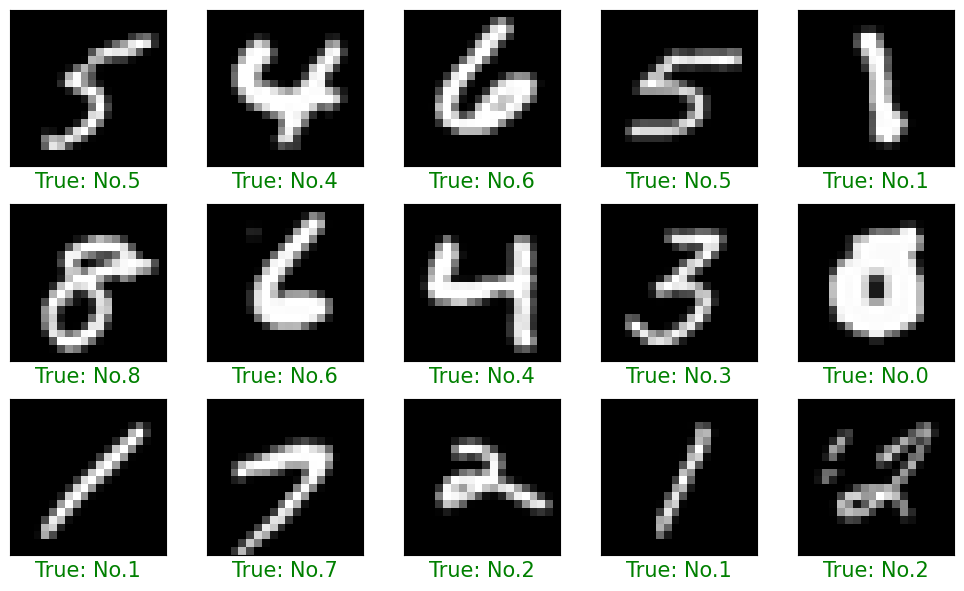

In [2623]:
plotData(X, y)

### Train & Test Split

In [2624]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2404)

### Image Pre-processing

- Reshaping it into the shape the model expects and scaling it so that all values are in the `[0, 1]` interval
- Transform from `unit8` it into a `float32`

In [2625]:
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [2626]:
X_train.shape, X_test.shape

((4000, 20, 20), (1000, 20, 20))

 - Rank-4 tensors of shape: `(samples, height, width, channels)`

In [2627]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [2628]:
X_train.shape, X_test.shape

((4000, 20, 20, 1), (1000, 20, 20, 1))

In [2629]:
import tensorflow as tf
import keras
from keras import layers

In [2630]:
# convert class vectors to binary class matrices: 1 => [0 1 0 0 ...]
# 1              => sparse_categorical_crossentropy
# [0 1 0 0 ...]  => categorical_crossentropy
nClasses = 10 # [0 1 2 3 4 5 6 7 8 9]

y_train_label = keras.utils.to_categorical(y_train, nClasses).astype(np.float32)
y_test_label = keras.utils.to_categorical(y_test, nClasses).astype(np.float32)

In [2631]:
y_train_label.shape

(4000, 10)

### ANNs

In [2632]:
keras.backend.clear_session()
model = keras.Sequential([
    keras.layers.Input(shape=[20, 20]),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [2633]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 256)               102656    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 119754 (467.79 KB)
Trainable params: 119754 (467.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model Compilation

In [2634]:

model.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [2635]:
# Training model

epochs = 10
batch_size = 64

history = model.fit(
    X_train,
    y_train_label,
    epochs = epochs,
    batch_size = batch_size,
    validation_split = 0.1
)

Epoch 1/10
57/57 [==============================] - 1s 8ms/step - loss: 0.8758 - accuracy: 0.7733 - val_loss: 0.5714 - val_accuracy: 0.8150
Epoch 2/10
57/57 [==============================] - 0s 7ms/step - loss: 0.3661 - accuracy: 0.9022 - val_loss: 0.5343 - val_accuracy: 0.8325
Epoch 3/10
57/57 [==============================] - 0s 5ms/step - loss: 0.2669 - accuracy: 0.9275 - val_loss: 0.4757 - val_accuracy: 0.8725
Epoch 4/10
57/57 [==============================] - 0s 3ms/step - loss: 0.2147 - accuracy: 0.9400 - val_loss: 0.3361 - val_accuracy: 0.9150
Epoch 5/10
57/57 [==============================] - 0s 3ms/step - loss: 0.1721 - accuracy: 0.9519 - val_loss: 0.3407 - val_accuracy: 0.9125
Epoch 6/10
57/57 [==============================] - 0s 3ms/step - loss: 0.1444 - accuracy: 0.9603 - val_loss: 0.2804 - val_accuracy: 0.9275
Epoch 7/10
57/57 [==============================] - 0s 3ms/step - loss: 0.1201 - accuracy: 0.9706 - val_loss: 0.2971 - val_accuracy: 0.9275
Epoch 8/10
57/57 [==

### Model Evaluation

In [2636]:
score = model.evaluate(X_test, y_test_label, verbose=0)

In [2637]:
print(f"Test Loss: {score[0]:.2f}")
print(f"Test Accuracy: {score[1]:.2f}")

Test Loss: 0.22
Test Accuracy: 0.94


In [2638]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [2639]:
train_loss, val_loss = history_dict['loss'], history_dict['val_loss']
train_accuracy, val_accuracy = history_dict['accuracy'], history_dict['val_accuracy']

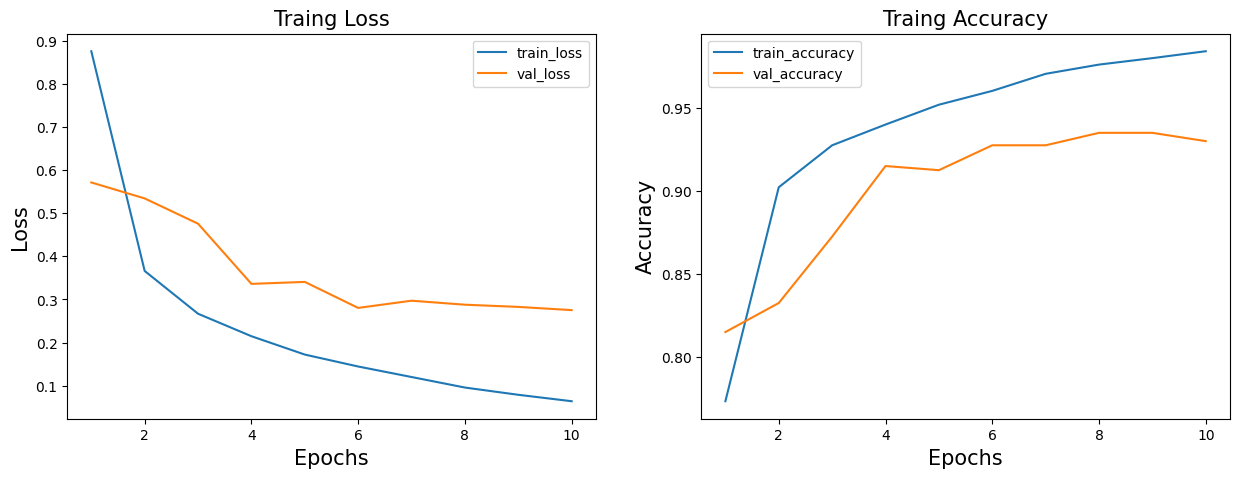

In [2640]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
lstEpoch = [i+1 for i in range(epochs)]

ax1.set_title("Traing Loss", fontsize=15)
ax1.plot(lstEpoch, train_loss)
ax1.plot(lstEpoch, val_loss)
ax1.set_xlabel("Epochs", fontsize=15)
ax1.set_ylabel("Loss",fontsize=15)
ax1.legend(title="", labels=["train_loss","val_loss"])

ax2.set_title("Traing Accuracy", fontsize=15)
ax2.plot(lstEpoch, train_accuracy)
ax2.plot(lstEpoch, val_accuracy)
ax2.legend(title="", labels=["train_accuracy","val_accuracy"])
ax2.set_xlabel("Epochs",fontsize=15)
ax2.set_ylabel("Accuracy",fontsize=15)

plt.show()

### Prediction

In [2641]:
X_sample = X_test[:3]
y_pred = model.predict(X_sample)

1/1 [==============================] - 0s 89ms/step


In [2642]:
y_test[:3]

array([8, 9, 0])

In [2643]:
y_pred.round(3)

array([[0.   , 0.001, 0.001, 0.003, 0.   , 0.   , 0.   , 0.   , 0.995,
        0.   ],
       [0.   , 0.   , 0.   , 0.001, 0.026, 0.   , 0.   , 0.01 , 0.   ,
        0.961],
       [1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]], dtype=float32)

In [2644]:
import pandas as pd
pd.DataFrame([[*y_p, class_names[y_l]] for y_p, y_l in zip(y_pred.round(3), y_test[:3])],
              columns=[*class_names, 'Label'])

,No.0,No.1,No.2,No.3,No.4,No.5,No.6,No.7,No.8,No.9,Label
0,0.0,0.001,0.001,0.003,0.000,0.0,0.0,0.00,0.995,0.000,No.8
1,0.0,0.000,0.000,0.001,0.026,0.0,0.0,0.01,0.000,0.961,No.9
2,1.0,0.000,0.000,0.000,0.000,0.0,0.0,0.00,0.000,0.000,No.0


In [2645]:
y_pred_all = model.predict(X_test)

32/32 [==============================] - 0s 2ms/step


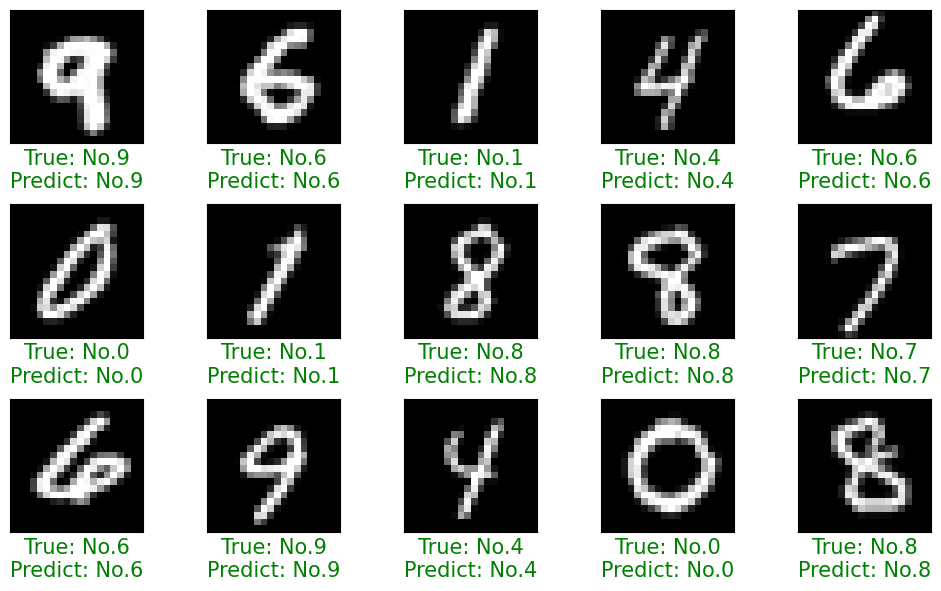

In [2650]:
plotData(X_test, y_test, y_pred_all)

In [2647]:
from sklearn.metrics import classification_report

print(classification_report(y_test, np.argmax(y_pred_all, axis=1), target_names=class_names))

              precision    recall  f1-score   support

        No.0       0.97      0.97      0.97       105
        No.1       0.93      0.96      0.94       112
        No.2       0.89      0.94      0.91        95
        No.3       0.98      0.93      0.96        92
        No.4       0.97      0.96      0.96       113
        No.5       0.88      0.98      0.93       102
        No.6       0.96      0.95      0.96       113
        No.7       0.91      0.94      0.92        84
        No.8       0.95      0.88      0.91        83
        No.9       0.97      0.89      0.93       101

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



### Save Models

In [2649]:
# SavedModel format
# model.save("/content/drive/MyDrive/Dataset/digitRecognition", save_format="tf")
# HDF5 format
# model.save("digitRecognition.keras")